<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Load-network" data-toc-modified-id="Load-network-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load network</a></span></li><li><span><a href="#Load-case" data-toc-modified-id="Load-case-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load case</a></span></li></ul></li><li><span><a href="#Let's-solve-the-carbon-minimization-problem" data-toc-modified-id="Let's-solve-the-carbon-minimization-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Let's solve the carbon minimization problem</a></span><ul class="toc-item"><li><span><a href="#Aggregrate-generation-by-resource" data-toc-modified-id="Aggregrate-generation-by-resource-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Aggregrate generation by resource</a></span></li></ul></li><li><span><a href="#Incorporate-prices" data-toc-modified-id="Incorporate-prices-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Incorporate prices</a></span></li></ul></div>

In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using Plots, Colors  # For plottig

using Revise
using CarbonNetworks

# Load data

## Load network

In [10]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators=1)
n = length(gmax)
m = length(pmax)

@show n, m

(n, m) = (380, 471)


(380, 471)

## Load case

In [137]:
case = DataFrame(CSV.File(CarbonNetworks.get_data_path(DATAPATH, "case_4.csv")))
rename!(case, "Column1" => "ba")
case = coalesce.(case, 0.0)

bas = case[:, "ba"]
demands = case[:, "net_demand"] - case[:, "WAT"]

d = zeros(n)
for (dem, ba) in zip(demands, bas)
    ind_d = findfirst(x -> x[2:3] == (ba, "DEMAND"), nodes)
    d[ind_d] = dem
end

@show sum(gmax)
@show sum(d);

sum(gmax) = 800797.7917451549
sum(d) = 264354.7671466503


# Let's solve the carbon minimization problem

In [4]:
primary_nodes = [ind for (ind, iso, res) in nodes if res == "DEMAND"]
primary_edges = [ind for (ind, e) in enumerate(edges(G)) 
        if e.src in primary_nodes && e.dst in primary_nodes];

In [151]:
# Scaling is important
scale = 1e4

d̃ = d / scale
g̃ = gmax / scale
p̃ = pmax / scale

# Make 'infinite' constraint large but not tight
p̃[p̃ .== Inf] .= 20 * maximum(g̃)
p̃ ./= 1.5


params = (f, d̃, p̃, g̃, A)

carbon_min = PowerManagementProblem(params...)
solve!(carbon_min, () -> ECOS.Optimizer(verbose=false))

g = evaluate(carbon_min.g)
p = evaluate(carbon_min.p)

println("Percent of power exchanged: $(sum(abs.(p[primary_edges])) / sum(d̃))")

@show maximum(abs.(p) - p̃)
@show maximum(g - gmax)
@show maximum(-g)
@show norm(A*p - g + d̃) / norm(d̃)

Percent of power exchanged: 0.08628018336681054
maximum(abs.(p) - p̃) = -3.617392496657601e-11
maximum(g - gmax) = 7.913856759657383e-11
maximum(-g) = 7.249754304165037e-13
norm((A * p - g) + d̃) / norm(d̃) = 1.0613280772596249e-10


1.0613280772596249e-10

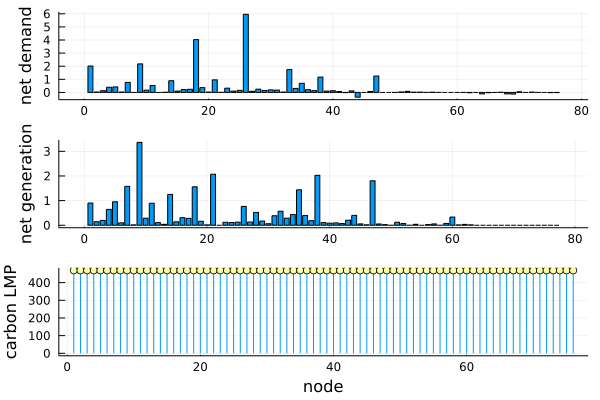

In [152]:
ν = get_lmps(carbon_min)[primary_nodes]
d_primary = d̃[primary_nodes]

push!(primary_nodes, lastindex(g))
g_primary = [sum(g[[tup[2] == nodes[i][2] for tup in nodes]]) for i in primary_nodes]
gmax_primary = [sum(g̃[[v[2] == nodes[i][2] for v in nodes]]) for i in primary_nodes]
pop!(primary_nodes)

gradient = cgrad(:inferno)
lmp_colors = [get(gradient, νi/maximum(ν)) for νi in ν]

plt1 = bar(d_primary, label=nothing, ylabel="net demand")
plt2 = bar(g_primary, label=nothing, ylabel="net generation")
#bar!(plt2, g_primary, label=nothing)

plt3 = sticks(ν, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, ν, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

## Aggregrate generation by resource

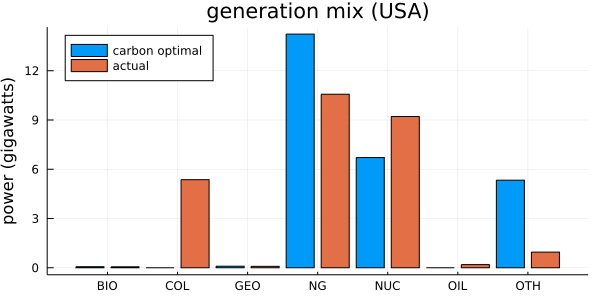

In [153]:
resources = unique([v[3] for v in nodes])
resources = resources[2:end-1]  # Remove demand and hydro

ba_id(ba) = findfirst(==(ba), bas)
res_id(res) = findfirst(==(res), resources)

gen_matrix = zeros(length(bas), length(resources))
gen_max_matrix = zeros(length(bas), length(resources))
for (id, ba, res) in nodes
    (res == "DEMAND" || res == "WAT") && continue

    #@show ba_id(ba), res_id(res)
    
    gen_matrix[ba_id(ba), res_id(res)] = g[id]
    gen_max_matrix[ba_id(ba), res_id(res)] = g̃[id]
end

max_dispatch = sum(gen_max_matrix, dims=1)[1, :]
carb_min_dispatch = sum(gen_matrix, dims=1)[1, :]
actual_dispatch = sum(Matrix(case[:, resources]), dims=1)[1, :] / scale

theme(:default)
x = 1:length(carb_min_dispatch)
plt = plot(size=(600, 300))
bar!(x .- 0.25, carb_min_dispatch, bar_width=0.4, label="carbon optimal")
bar!(x .+ 0.25, actual_dispatch, bar_width=0.4, label="actual")
plot!(xticks=(1:length(carb_min_dispatch), resources), ylabel="power (gigawatts)")
plot!(legend=:topleft, title="generation mix (USA)")
savefig(plt, "./gen_mix.png")
display(plt)

# Incorporate prices

In [176]:
df_types = append!(Any[String], [Union{Float64, Missing} for _ in 1:7])
df_cost = DataFrame(CSV.File(
        joinpath(DATAPATH, "monetary_costs.csv"), 
        types=df_types,
))
rename!(df_cost, 
    "Column1" => "BA", "gas" => "NG", "coal" => "COL", "oil" => "OIL",
    "nuclear" => "NUC", "hydro" => "WAT", "geothermal" => "GEO", "biomass" => "BIO"
)



# Fill missing values
estimated_mean = res -> mean(df_cost[.! ismissing.(df_cost[:, res]), res])

df_cost[ismissing.(df_cost.NG), "NG"] .= estimated_mean("NG")
df_cost[ismissing.(df_cost.COL), "COL"] .= 60.0
df_cost[ismissing.(df_cost.OIL), "OIL"] .= estimated_mean("OIL")
df_cost[:, "NUC"] .= 30.4
df_cost[:, "WAT"] .= 0.0
df_cost[:, "GEO"] .= 0.0
df_cost[ismissing.(df_cost.BIO), "BIO"] .= estimated_mean("BIO")


f_dollar = zeros(length(d))
for (i, ba, res) in nodes
    (res in ["DEMAND", "WAT", "OTH"]) && continue
    arr = df_cost[df_cost.BA .== ba, res]
    f_dollar[i] = isempty(arr) ? estimated_mean(res) : arr[1]
end

df_cost

,BA,NG,COL,OIL,NUC,WAT,GEO,BIO
,String,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,ERCO,19.6126,19.9541,117.459,30.4,0.0,0.0,43.9262
2,SWPP,35.4141,17.9909,117.459,30.4,0.0,0.0,64.9239
3,MISO,36.1792,23.8681,170.969,30.4,0.0,0.0,148.975
4,CISO,31.5542,0.0,117.459,30.4,0.0,0.0,63.6307
5,PSCO,32.2751,24.8111,117.459,30.4,0.0,0.0,64.9239
6,NEVP,37.0879,22.5911,117.459,30.4,0.0,0.0,64.9239
7,AZPS,38.693,24.5698,117.459,30.4,0.0,0.0,64.9239
8,TEPC,40.2294,18.0537,117.459,30.4,0.0,0.0,64.9239
9,SRP,24.4671,23.9103,117.459,30.4,0.0,0.0,64.9239


In [177]:
dollar_params = (f_dollar, d̃, p̃, g̃, A)

opf = PowerManagementProblem(dollar_params...)
solve!(opf, () -> ECOS.Optimizer(verbose=false))

gd = evaluate(opf.g)
pd = evaluate(opf.p)

println("Percent of power exchanged: $(sum(abs.(pd[primary_edges])) / sum(d̃))")

@show maximum(abs.(pd) - p̃)
@show maximum(gd - gmax)
@show maximum(-gd)
@show norm(A*pd - gd + d̃)

Percent of power exchanged: 0.0736228194024191
maximum(abs.(pd) - p̃) = -6.071071423363605e-11
maximum(gd - gmax) = 5.220875531769547e-13
maximum(-gd) = 4.181543055703411e-12
norm((A * pd - gd) + d̃) = 2.884998442378813e-10


2.884998442378813e-10

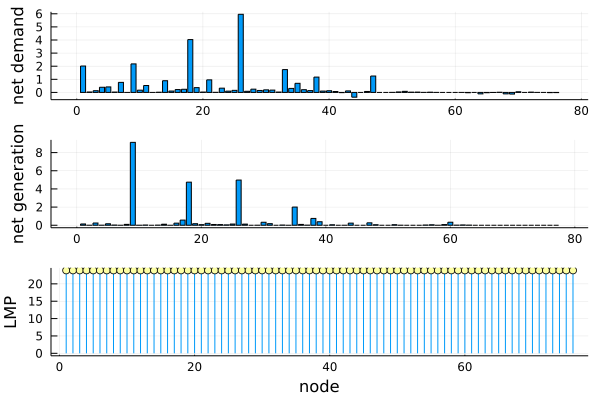

In [178]:
ν = get_lmps(opf)[primary_nodes]

push!(primary_nodes, lastindex(g))
g_primary = [sum(gd[[tup[2] == nodes[i][2] for tup in nodes]]) for i in primary_nodes]
pop!(primary_nodes)

gradient = cgrad(:inferno)
lmp_colors = [get(gradient, νi/maximum(ν)) for νi in ν]

plt1 = bar(d_primary, label=nothing, ylabel="net demand")
plt2 = bar(g_primary, label=nothing, ylabel="net generation")
#bar!(plt2, g_primary, label=nothing)

plt3 = sticks(ν, label=nothing, ylabel="LMP", xlabel="node")
scatter!(plt3, ν, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))

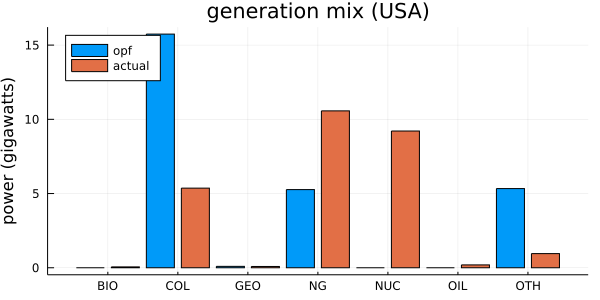

In [180]:
resources = unique([v[3] for v in nodes])
resources = resources[2:end-1]  # Remove demand and hydro

ba_id(ba) = findfirst(==(ba), bas)
res_id(res) = findfirst(==(res), resources)

gen_matrix = zeros(length(bas), length(resources))
gen_max_matrix = zeros(length(bas), length(resources))
for (id, ba, res) in nodes
    (res == "DEMAND" || res == "WAT") && continue

    #@show ba_id(ba), res_id(res)
    
    gen_matrix[ba_id(ba), res_id(res)] = gd[id]
    gen_max_matrix[ba_id(ba), res_id(res)] = g̃[id]
end

max_dispatch = sum(gen_max_matrix, dims=1)[1, :]
opf_dispatch = sum(gen_matrix, dims=1)[1, :]
actual_dispatch = sum(Matrix(case[:, resources]), dims=1)[1, :] / scale

theme(:default)
x = 1:length(opf_dispatch)
plt = plot(size=(600, 300))
bar!(x .- 0.25, opf_dispatch, bar_width=0.4, label="opf")
bar!(x .+ 0.25, actual_dispatch, bar_width=0.4, label="actual")
plot!(xticks=(1:length(opf_dispatch), resources), ylabel="power (gigawatts)")
plot!(legend=:topleft, title="generation mix (USA)")
savefig(plt, "./gen_mix.png")
display(plt)